# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [18]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/skundu/ssd.pytorch/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [19]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('/home/skundu/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...


/home/skundu/ssd.pytorch/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


FileNotFoundError: [Errno 2] No such file or directory: '/home/skundu/ssd300_mAP_77.43_v2.pth'

## Load Image 
### Here we just load a sample image from the VOC07 dataset 

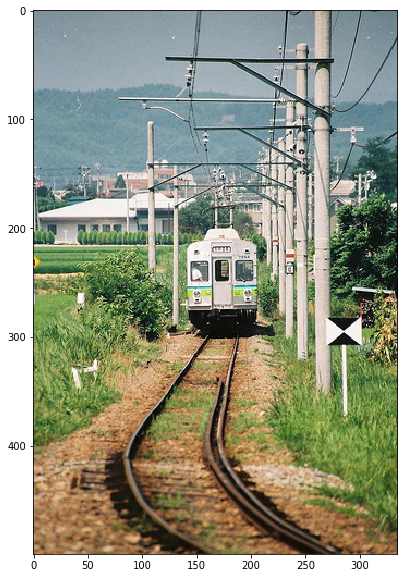

In [20]:
#image = cv2.imread('/home/skundu/ssd.pytorch/data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'test')], None, VOCAnnotationTransform())
img_id = 1
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


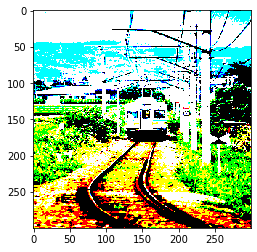

In [196]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [197]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)
#y.data

/opt/conda/conda-bld/pytorch_1579040055865/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579040055865/work/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
torch.Size([1, 21, 200, 5])
21
tensor([335., 500., 335., 500.])
tensor(0.9999)
train
[140.30656 197.03912 206.60023 299.96985]
((140.30656, 197.03912), 67.29367065429688, 103.93072509765625)
tensor([0., 0., 0., 0.])
m =  2


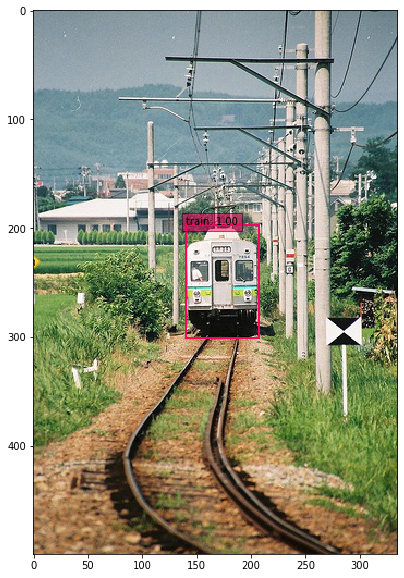

In [334]:
from data import VOC_CLASSES as labels
top_k=10
print(labels)
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
#print(colors)

detections = y.data
print(detections.size())
# scale each detection back up to the image
print(detections.size(1))
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
print(scale)
m = 1
for i in range(detections.size(1)):
    j = 0
    
    while detections[0,i,j,0] > 0.50:
        score = detections[0,i,j,0]
        print(score)
        
        label_name = labels[i-1]
        print(label_name)
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
        m = m+1
        print(pt)
        print(coords)
print(detections[0, 5, 0, 1:])
print("m = ", m)
#detections[0, 15]


In [165]:
if ('/home/skundu/data/VOCdevkit/VOC2012/ImageSets/Main/' == '/home/skundu/data/VOCdevkit/VOC2007/ImageSets/Main'):
    print("True")
else:
    print("False"
          
detections[0, 15]

SyntaxError: invalid syntax (<ipython-input-165-86fa14e11fed>, line 6)

In [34]:
import torch


print(torch.__version__)

1.4.0


In [35]:
def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

In [47]:
str2bool("yes")

True

In [58]:



file = open("/home/skundu/data/VOCdevkit/VOC2007/ImageSets/Main/test.txt")
data = file.read()
words = data.split()

print('Number of words in text file :', len(words))

Number of words in text file : 4952


['boat_pr.pkl', 'pottedplant_pr.pkl', 'bird_pr.pkl', 'aeroplane_pr.pkl', 'bottle_pr.pkl', 'bicycle_pr.pkl', 'sofa_pr.pkl', 'motorbike_pr.pkl', 'horse_pr.pkl', 'bus_pr.pkl', 'cat_pr.pkl', 'dog_pr.pkl', 'diningtable_pr.pkl', 'cow_pr.pkl', 'chair_pr.pkl', 'tvmonitor_pr.pkl', 'car_pr.pkl', 'train_pr.pkl', 'sheep_pr.pkl', 'person_pr.pkl']
[0.00380228 0.00760456 0.01140684 ... 0.81368821 0.81368821 0.81368821]
[0.00208333 0.00416667 0.00625    ... 0.71875    0.71875    0.71875   ]
[0.00217865 0.0043573  0.00653595 ... 0.79956427 0.79956427 0.79956427]
[0.00350877 0.00701754 0.01052632 ... 0.87368421 0.87368421 0.87368421]
[0.0021322  0.0021322  0.00426439 ... 0.65671642 0.65671642 0.65671642]
[0.00296736 0.00593472 0.00890208 ... 0.89910979 0.89910979 0.89910979]
[0.0041841  0.0083682  0.0125523  ... 0.92050209 0.92050209 0.92050209]
[0.00307692 0.00615385 0.00923077 ... 0.88615385 0.88615385 0.88615385]
[0.00287356 0.00574713 0.00862069 ... 0.90804598 0.90804598 0.90804598]
[0.00469484 0.00

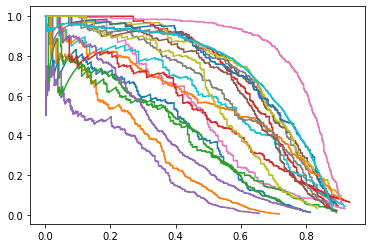

In [91]:
import os
import pandas as pd
basepath = '/home/skundu/ssd.pytorch/ssd300_120000/test/'
entries = os.listdir('/home/skundu/ssd.pytorch/ssd300_120000/test/')
print(entries)
for i in range(len(entries)):
    indiv_path = basepath + entries[i]
    objects = pd.read_pickle(indiv_path)
    print(objects['rec'])
    plt.plot(objects['rec'], objects['prec'])
print(objects['rec'])
    #objects = pd.read_pickle(indiv_path)
    #print(objects)
    #precision = objects['prec']
    #print(precision)
    #recall = objects['rec']
    #plt.plot(recall, precision)
      
    


In [89]:
objects = pd.read_pickle(basepath +entries[1])
print(objects[2][0])

#objects['rec'][100]
#objects.items()

[[3.7231584e+00 1.8239148e+02 3.3917151e+02 4.9128717e+02 3.2687355e-02]
 [3.1611374e+02 2.0499280e+02 3.5381055e+02 2.5634863e+02 1.0747101e-02]]


In [32]:
precision = objects['prec']
recall = objects['rec']
len(precision)
len(recall)
total = 0
for i in range(0,len(recall)):
    total = total + precision[i]
print(total)
ap = total/5858
print(ap)




TypeError: list indices must be integers or slices, not str

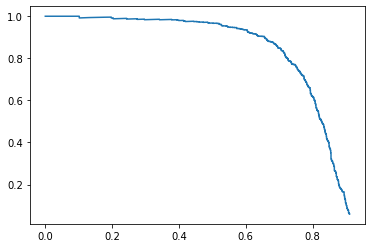

In [26]:
plt.plot(recall, precision)

In [445]:
file = open("/home/skundu/ssd.pytorch/eval/predictions3.txt")
file = str(file.read())
#print(file)
prediction_list = []
for k in range(1, 101):
    pred = file.split('@')[k]
    prediction_list.append(pred)
    
print(prediction_list)


['1 bottle tensor(0.0126) 267.6166 98.03 291.5408 161.7249\n2 chair tensor(0.1079) 14.227661 38.97008 344.58 485.06244\n3 chair tensor(0.0248) 54.354935 419.5275 124.15268 482.1376\n4 chair tensor(0.0174) 86.89016 440.54498 162.14087 495.75412\n5 chair tensor(0.0145) 142.05746 215.17062 195.98479 289.09033\n6 chair tensor(0.0143) 79.375 435.64008 120.340385 481.66425\n7 chair tensor(0.0129) 18.69444 223.37918 270.3085 470.89267\n8 dog tensor(0.5328) 41.136562 235.98322 210.37006 384.10025\n9 dog tensor(0.2517) 18.69444 223.37918 270.3085 470.89267\n10 dog tensor(0.0125) 14.227661 38.97008 344.58 485.06244\n11 person tensor(0.9842) 20.961044 -0.95807016 347.89233 497.01297\n12 sofa tensor(0.0241) 14.227661 38.97008 344.58 485.06244\nPREDICTIONS for image id: 000002', '1 aeroplane tensor(0.0412) 2.0374095 131.21812 57.12596 205.29121\n2 aeroplane tensor(0.0232) 16.866972 142.32056 61.357834 184.62276\n3 aeroplane tensor(0.0185) 94.46536 62.499477 140.88719 91.73502\n4 aeroplane tensor(0.

In [361]:
import re
file = open("/home/skundu/ssd.pytorch/eval/predictions3.txt")
x = str(file.read())
x = x.split('@')[2]
x = x.split('\n')
#print(len(x))
#print(x[1])
new_list = []
table = str.maketrans(dict.fromkeys('()'))
for j in range(0,len(x)-1):
    #print(x[j])
    x[j] = re.sub('tensor', ' ', x[j])
    
    p = x[j].split(' ')
    del p[2], p[0]
    p[1] = p[1].translate(table)
    
    #print(p)
    
    for i in range(1, 6):
        p[i] = float(p[i])
    #p[4]=p[4]-p[2]+1
    #p[5] = p[5]-p[3]+1
    new_list.append(p)
    #print(p)

print(new_list)


[['aeroplane', 0.0412, 2.0374095, 131.21812, 57.12596, 205.29121], ['aeroplane', 0.0232, 16.866972, 142.32056, 61.357834, 184.62276], ['aeroplane', 0.0185, 94.46536, 62.499477, 140.88719, 91.73502], ['aeroplane', 0.0159, 3.636284, 146.77249, 44.451782, 184.75208], ['aeroplane', 0.0148, 77.095856, 46.615467, 149.19424, 100.35613], ['aeroplane', 0.0148, 47.04184, 122.576744, 172.90192, 175.4076], ['aeroplane', 0.0138, 77.43521, 71.55488, 130.83447, 94.919334], ['bird', 0.0133, 295.72733, 100.7865, 336.1076, 133.43497], ['boat', 0.0308, 0.9981207, 133.42967, 52.426476, 194.9601], ['boat', 0.0122, 19.684471, 140.33565, 66.29529, 180.12807], ['boat', 0.0118, 0.8851493, 140.34346, 26.560272, 202.17763], ['boat', 0.0104, 95.69238, 163.31935, 146.53429, 189.88828], ['bus', 0.0222, 148.03587, 200.22136, 203.3418, 291.09583], ['bus', 0.0121, 143.27359, 210.37961, 167.43715, 278.97263], ['car', 0.0159, 289.74625, 250.46796, 331.7706, 283.49603], ['car', 0.0157, 6.02636, 200.90977, 23.898537, 217.

In [362]:
x = new_list
print(x)

[['aeroplane', 0.0412, 2.0374095, 131.21812, 57.12596, 205.29121], ['aeroplane', 0.0232, 16.866972, 142.32056, 61.357834, 184.62276], ['aeroplane', 0.0185, 94.46536, 62.499477, 140.88719, 91.73502], ['aeroplane', 0.0159, 3.636284, 146.77249, 44.451782, 184.75208], ['aeroplane', 0.0148, 77.095856, 46.615467, 149.19424, 100.35613], ['aeroplane', 0.0148, 47.04184, 122.576744, 172.90192, 175.4076], ['aeroplane', 0.0138, 77.43521, 71.55488, 130.83447, 94.919334], ['bird', 0.0133, 295.72733, 100.7865, 336.1076, 133.43497], ['boat', 0.0308, 0.9981207, 133.42967, 52.426476, 194.9601], ['boat', 0.0122, 19.684471, 140.33565, 66.29529, 180.12807], ['boat', 0.0118, 0.8851493, 140.34346, 26.560272, 202.17763], ['boat', 0.0104, 95.69238, 163.31935, 146.53429, 189.88828], ['bus', 0.0222, 148.03587, 200.22136, 203.3418, 291.09583], ['bus', 0.0121, 143.27359, 210.37961, 167.43715, 278.97263], ['car', 0.0159, 289.74625, 250.46796, 331.7706, 283.49603], ['car', 0.0157, 6.02636, 200.90977, 23.898537, 217.

Text(125, 200, 'Train, 1.00')

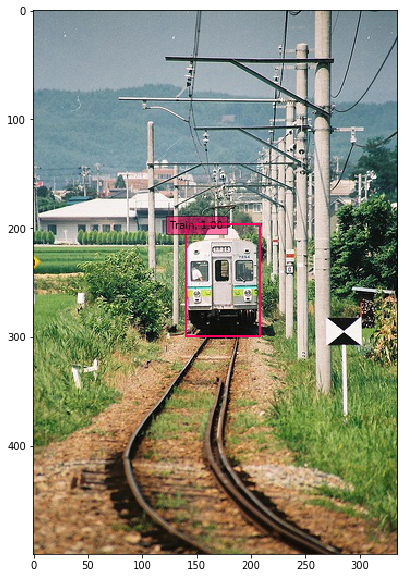

In [347]:

plt.figure(figsize=(10,10))

plt.imshow(rgb_image) # plot the image for matplotlib

currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle((139.70316, 196.18417), 68.57992000000002, 103.27404999999999, fill=False, edgecolor=color, linewidth=2))
currentAxis.text(125, 200, "Train, 1.00", bbox={'facecolor':color, 'alpha':0.5})

In [399]:

def get_iou(x1, y1, x2, y2, X1, Y1, X2,Y2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    x1, y1, x2, y2 are the coordinates of bounding box1
    X1, Y1, X2, Y2 are the coordinates of bounding box2

    Returns:
    IOU in floats in range (0, 1)
    """
    assert x1 < x2
    assert y1 < y2
    assert X1 < X2
    assert Y1 < Y2

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, X1)
    y_top = max(y1, Y1)
    x_right = min(x2, X2)
    y_bottom = min(y2, Y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (abs(x2 - x1)) * (abs(y2 - y1))
    bb2_area = (abs(X2 - X1)) * (abs(Y2 - Y1))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [369]:
get_iou(x[0][2],x[0][3],x[0][4],x[0][5], x[1][2],x[1][3],x[1][4],x[1][5])

0.39981337819832324

In [398]:
assert x[0][2] < x[0][4]
assert x[0][3] < x[0][5]
assert x[1][2] < x[1][4]
assert x[1][3] < x[1][5]

# determine the coordinates of the intersection rectangle
x_left = max(x[0][2], x[1][2])
y_top = max(x[0][3], x[1][3])
x_right = min(x[0][4], x[1][4])
y_bottom = min(x[0][5], x[1][5])

if x_right < x_left or y_bottom < y_top:
    print("none")

# The intersection of two axis-aligned bounding boxes is always an
# axis-aligned bounding box
intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
bb1_area = (abs(x[0][4] - x[0][2])) * (abs(x[0][5] - x[0][3]))
bb2_area = (abs(x[1][4] - x[1][2])) * (abs(x[1][5] - x[1][3]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
assert iou >= 0.0
assert iou <= 1.0
print(iou)

0.39981337819832324


In [415]:
iou_list = []
for i in range(0,len(x)-1):
    for j in range(i+1, len(x)):
        area = get_iou(x[i][2],x[i][3],x[i][4],x[i][5], x[j][2],x[j][3],x[j][4],x[j][5])
        if area>= 1:
            iou_list.append(area)
    

In [416]:
print(len(iou_list))

6


In [417]:
len(x)

107

In [411]:
print(iou_list)

[0.39981337819832324, 0.3798862414438315, 0.7480855824309562, 0.3351489262810839, 0.3652248530511661, 0.4372018343506584, 0.4246611350485083, 0.7290060087628252, 0.3502715552459418, 0.39229369388667495, 0.4898721909586926, 0.32035550765820714, 0.3840320287771911, 0.3220047843786074, 0.330307347111518, 0.8041243750922502, 0.3093966896104072, 0.3505878842694097, 0.41602044637043395, 0.7762971011596808, 0.3380730625209199, 0.727160807323325, 0.30228387627910286, 0.3016922131982944, 0.3487259342337596, 0.32011751376665176, 0.3739450014945524, 1.0, 0.30277433814780913, 0.41395770055387465, 0.45734669820317914, 0.34991761387851095, 0.30027606145420394, 0.33107085611841564, 0.7391804478580584, 0.30668000581892346, 0.3223677900805357, 0.4173709384023548, 1.0, 0.4040020036791472, 0.3529394665279322, 0.3996974121639842, 1.0, 0.39113061182584147, 0.42499019700985463, 0.4053061534797842, 0.3752555005410224, 0.31094019857154565, 0.37802518553703945, 0.32436597626277064, 0.625993449991081, 0.4372788